<a href="https://colab.research.google.com/github/BRIJNANDA1979/Segmenting-Kelp-Forests-/blob/main/Pre_trained_CNN_for_KELP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/mrjouh4/satellite-image-classification-cnn-pretrained

In [1]:
import os
import PIL
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.applications import MobileNetV2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Make DataFrame for Image pathes and their labels
data = pd.DataFrame(columns=["image_path", "label"])
# Define Classes
data_path = "/content/drive/MyDrive/data"
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        label = folder
        data = data.append({"image_path": image_path, "label": label}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-3-7b45713ccdd6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"image_path": image_path, "label": label}, ignore_index=True)
<ipython-input-3-7b45713ccdd6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"image_path": image_path, "label": label}, ignore_index=True)
<ipython-input-3-7b45713ccdd6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"image_path": image_path, "label": label}, ignore_index=True)
<ipython-input-3-7b45713ccdd6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({"im

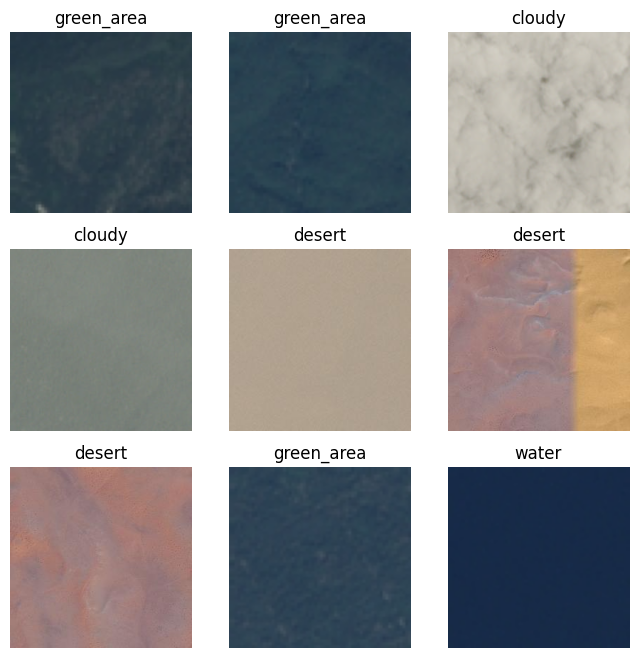

In [4]:
# Generate 9 random indices
indices = random.sample(range(5600), 9)

# Define the figure size and layout
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

# Loop over the axes and plot the corresponding images
for i, ax in enumerate(axes.flat):
    # Get the image and label for the current index
    img = plt.imread(data.iloc[indices[i]].image_path)
    label = data.iloc[indices[i]].label

    # Plot the image and label
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

# Show the plot
plt.show()

In [5]:
train_df, val_test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode="categorical")

Found 5425 validated image filenames belonging to 4 classes.


In [7]:

val_generator = test_datagen.flow_from_dataframe(dataframe=val_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(256, 256),
                                                  batch_size=32,
                                                  class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(256, 256),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 678 validated image filenames belonging to 4 classes.
Found 679 validated image filenames belonging to 4 classes.


In [8]:
# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from convolutional layers
model.add(Flatten())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator)

170/170 [==============================] - 513s 3s/step - loss: 0.8138 - accuracy: 0.6157 - val_loss: 0.5865 - val_accuracy: 0.7448


In [11]:
score = model.evaluate(test_generator)

22/22 [==============================] - 88s 4s/step - loss: 0.5976 - accuracy: 0.7202


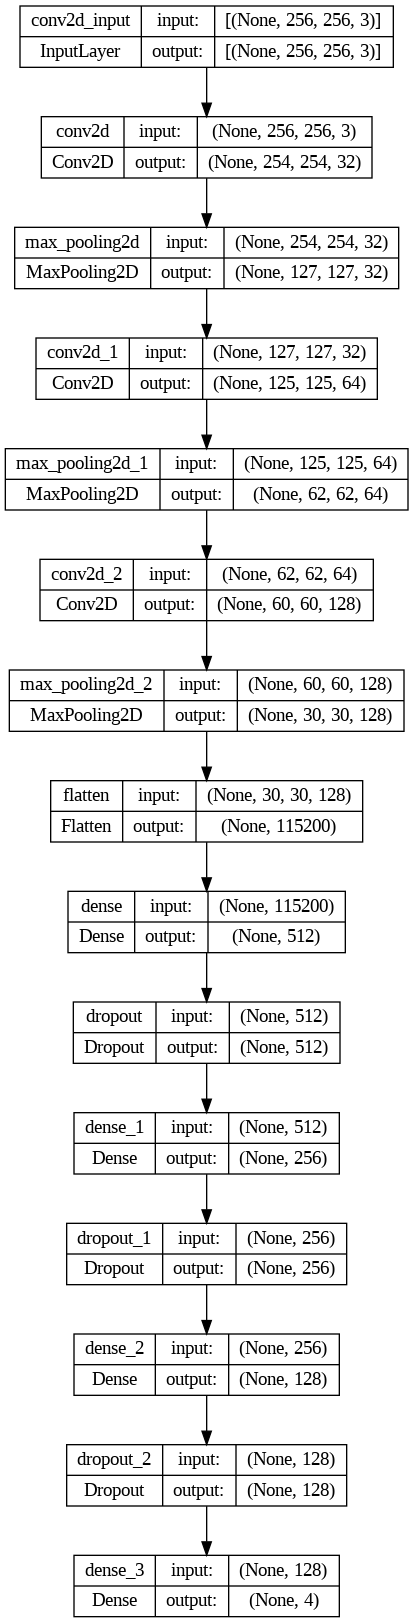

In [12]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator_vgg = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode="categorical")

val_generator_vgg = test_datagen.flow_from_dataframe(dataframe=val_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")

test_generator_vgg = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 5425 validated image filenames belonging to 4 classes.
Found 678 validated image filenames belonging to 4 classes.
Found 679 validated image filenames belonging to 4 classes.


In [16]:
vgg_model =  VGG19(include_top=True , weights='imagenet')
for models in vgg_model.layers:
      models.trainable= False

574710816/574710816 [==============================] - 3s 0us/step


In [17]:
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)
model = Sequential()
for layer in vgg_model.layers:
      model.add(layer)

model.add(Dense(4, activation='softmax'))

In [18]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

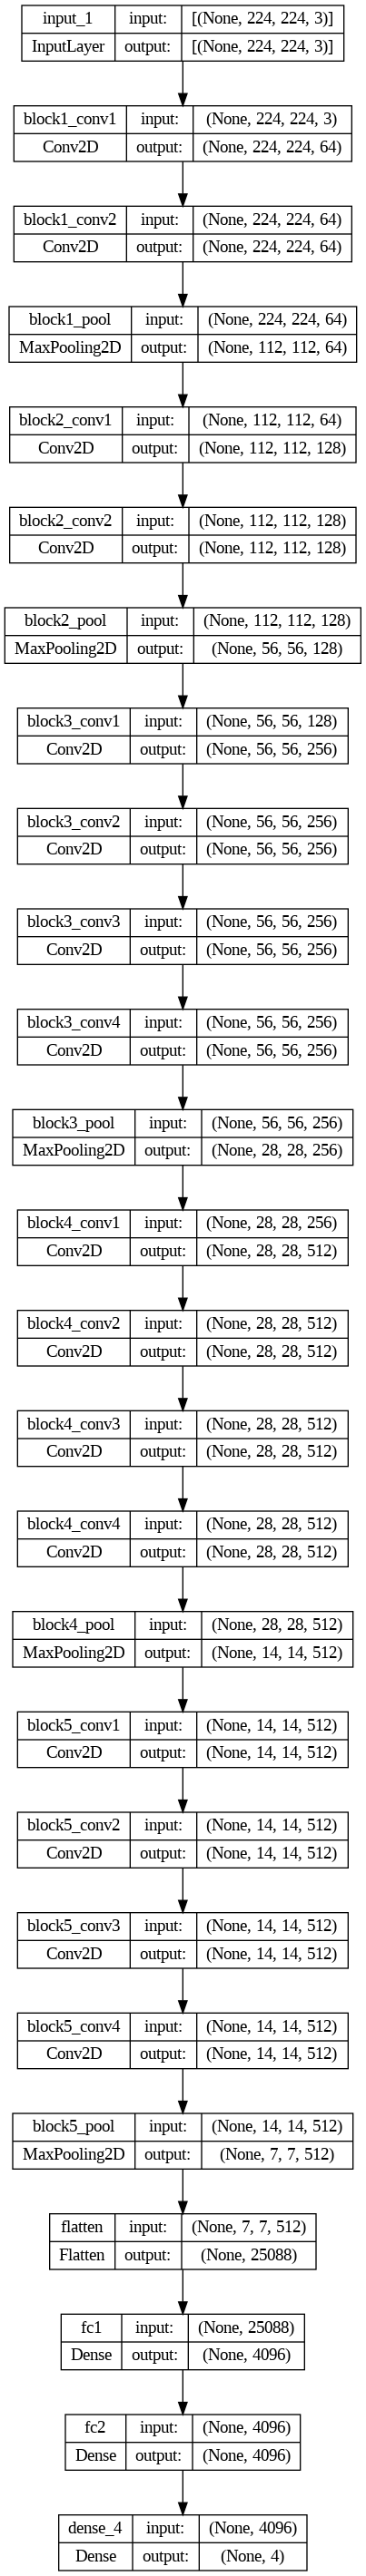

In [19]:
plot_model(model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('vgg_model.png'))

In [21]:
history_vgg =model.fit(train_generator_vgg,
    validation_data = val_generator_vgg,
    epochs = 2)

Epoch 1/2
170/170 [==============================] - 255s 1s/step - loss: 0.8368 - accuracy: 0.7331 - val_loss: 0.7173 - val_accuracy: 0.8673
Epoch 2/2
170/170 [==============================] - 256s 2s/step - loss: 0.6872 - accuracy: 0.8026 - val_loss: 0.6402 - val_accuracy: 0.8938


In [22]:
model.evaluate(test_generator_vgg)

22/22 [==============================] - 28s 1s/step - loss: 0.6272 - accuracy: 0.8999


[0.6272423267364502, 0.8998527526855469]

In [72]:
model.predict(test_generator_vgg)

22/22 [==============================] - 27s 1s/step


array([[1.91379040e-01, 2.47138709e-01, 4.70958292e-01, 9.05238315e-02],
       [6.63986862e-01, 2.45852947e-01, 2.45547947e-02, 6.56053573e-02],
       [3.96464080e-01, 5.05020320e-01, 4.83151302e-02, 5.02005480e-02],
       ...,
       [4.42264564e-02, 9.26761150e-01, 2.60731317e-02, 2.93929619e-03],
       [1.06473856e-01, 1.59639388e-01, 5.85799158e-01, 1.48087472e-01],
       [1.01805339e-02, 9.83701587e-01, 5.88146131e-03, 2.36447173e-04]],
      dtype=float32)

In [162]:
from PIL import Image                 ################  Image preprocessing...conversion tif to jpg and rescaling to 224 size
path = '/content/drive/MyDrive/181'
files_list = os.listdir(path)
for i in files_list:
  with rasterio.open('/content/drive/MyDrive/181/' + i ) as src:
    red = src.read(3)  ##RED band
    green = src.read(4)  ##GREEN band
    blue = src.read(5)  ##BLUE band
    #im = src.read([3,4,5])  ##RED green blue bands
    #im = im.astype('float64')
    #im =im.reshape(im.shape[1],im.shape[2],im.shape[0])
    imarray_green =green
    imarray_red = red
    imarray_blue = blue
    #imarray = np.dstack((imarray_red, imarray_green, imarray_blue))
    import numpy as np
    from PIL import Image, ImageOps
    img_green = (np.maximum(imarray_green, 0) / imarray_green.max()) * 255.0
    img_red = (np.maximum(imarray_red, 0) / imarray_red.max()) * 255.0
    img_blue = (np.maximum(imarray_blue, 0) / imarray_blue.max()) * 255.0
    #print(img)
    img_green = 255 - img_green #Inverting the pixel
    img_red = 255 - img_red #Inverting the pixel
    img_blue = 255 - img_blue #Inverting the pixel
    #print("********************************************************************")

    img_green = Image.fromarray(np.uint8(img_green))
    img_red = Image.fromarray(np.uint8(img_red))
    img_blue = Image.fromarray(np.uint8(img_blue))

    s =i.split('.')
    ss = s[0]+'.jpg'
    img_green.save('/content/drive/MyDrive/181GREEN/' + ss)
    img_red.save('/content/drive/MyDrive/181RED/' + ss)
    img_blue.save('/content/drive/MyDrive/181BLUE/' + ss)
    #plt.imshow(img)
    #plt.show()


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [163]:
from PIL import Image
path = '/content/drive/MyDrive/181GREEN'  #### all 3 folders contain same name of files only different bands
files_list = os.listdir(path)
for i in files_list:
  im_green= Image.open('/content/drive/MyDrive/181GREEN/' + i)
  im_red = Image.open('/content/drive/MyDrive/181RED/' + i)
  im_blue = Image.open('/content/drive/MyDrive/181BLUE/' + i)

  im_green = im_green.convert('RGB')
  im_red = im_red.convert('RGB')
  im_blue = im_blue.convert('RGB')

  #im = im.convert('RGB')                                         ### Resizing
  im_green = im_green.resize((224,224))
  im_red = im_red.resize((224,224))
  im_blue = im_blue.resize((224,224))
  im_green.save('/content/drive/MyDrive/181GREEN/' + i)
  im_red.save('/content/drive/MyDrive/181RED/' + i)
  im_blue.save('/content/drive/MyDrive/181BLUE/' + i)

  #plt.imshow(im)
  #plt.show()

In [167]:
path_green = '/content/drive/MyDrive/181GREEN'
path_red = '/content/drive/MyDrive/181RED'
path_blue = '/content/drive/MyDrive/181BLUE'
files_list = os.listdir(path)
X_green =[]
X_red =[]
X_blue =[]
y=[]
for i in files_list:
  X_green.append(path_green+'/' + i)
  X_red.append(path_red+'/' + i)
  X_blue.append(path_blue+'/' + i)
  y.append('green_area')


In [169]:
mytest_df = pd.DataFrame({'image_path_green':X_green,'image_path_red':X_red,'image path blue':X_blue ,'label':y})
mytest_df

,image_path_green,image_path_red,image path blue,label
0,/content/drive/MyDrive/181GREEN/HP480632_kelp.jpg,/content/drive/MyDrive/181RED/HP480632_kelp.jpg,/content/drive/MyDrive/181BLUE/HP480632_kelp.jpg,green_area
1,/content/drive/MyDrive/181GREEN/HS536802_kelp.jpg,/content/drive/MyDrive/181RED/HS536802_kelp.jpg,/content/drive/MyDrive/181BLUE/HS536802_kelp.jpg,green_area
2,/content/drive/MyDrive/181GREEN/HT473321_kelp.jpg,/content/drive/MyDrive/181RED/HT473321_kelp.jpg,/content/drive/MyDrive/181BLUE/HT473321_kelp.jpg,green_area
3,/content/drive/MyDrive/181GREEN/HY117531_kelp.jpg,/content/drive/MyDrive/181RED/HY117531_kelp.jpg,/content/drive/MyDrive/181BLUE/HY117531_kelp.jpg,green_area
4,/content/drive/MyDrive/181GREEN/IA161248_kelp.jpg,/content/drive/MyDrive/181RED/IA161248_kelp.jpg,/content/drive/MyDrive/181BLUE/IA161248_kelp.jpg,green_area
...,...,...,...,...
176,/content/drive/MyDrive/181GREEN/GS470037_kelp.jpg,/content/drive/MyDrive/181RED/GS470037_kelp.jpg,/content/drive/MyDrive/181BLUE/GS470037_kelp.jpg,green_area
177,/content/drive/MyDrive/181GREEN/HC584887_kelp.jpg,/content/drive/MyDrive/181RED/HC584887_kelp.jpg,/content/drive/MyDrive/181BLUE/HC584887_kelp.jpg,green_area
178,/content/drive/MyDrive/181GREEN/HE845609_kelp.jpg,/content/drive/MyDrive/181RED/HE845609_kelp.jpg,/content/drive/MyDrive/181BLUE/HE845609_kelp.jpg,green_area
179,/content/drive/MyDrive/181GREEN/HO507341_kelp.jpg,/content/drive/MyDrive/181RED/HO507341_kelp.jpg,/content/drive/MyDrive/181BLUE/HO507341_kelp.jpg,green_area


In [170]:
mytest_df_green = pd.DataFrame({'image_path':X_green,'label':y})
mytest_df_red = pd.DataFrame({'image_path':X_red,'label':y})
mytest_df_blue = pd.DataFrame({'image_path':X_blue,'label':y})

In [172]:
test_generator_vgg_green = test_datagen.flow_from_dataframe(dataframe=mytest_df_green,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")
test_generator_vgg_red = test_datagen.flow_from_dataframe(dataframe=mytest_df_red,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")
test_generator_vgg_blue = test_datagen.flow_from_dataframe(dataframe=mytest_df_blue,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 181 validated image filenames belonging to 1 classes.
Found 181 validated image filenames belonging to 1 classes.
Found 181 validated image filenames belonging to 1 classes.


In [173]:
predictions_green = model.predict(test_generator_vgg_green)
predictions_red = model.predict(test_generator_vgg_red)
predictions_blue = model.predict(test_generator_vgg_blue)

6/6 [==============================] - 7s 1s/step


In [175]:
y_predicted_green =[]
y_predicted_red =[]
y_predicted_blue =[]
for i in predictions_green:
  #print(i[2])
  y_predicted_green.append(i[2])           ### category 3 is for Green_area in trained VGG on 4 category data [cloudy,desert,green_area,water]
for i in predictions_red:
  y_predicted_red.append(i[2])
for i in predictions_blue:
  y_predicted_blue.append(i[2])

In [176]:
mytest_df_green['predictions_green'] = y_predicted_green
mytest_df_red['predictions_red'] = y_predicted_red
mytest_df_blue['predictions_blue'] = y_predicted_blue

In [180]:
mytest_df_green

,image_path,label,predictions_green
0,/content/drive/MyDrive/181GREEN/HP480632_kelp.jpg,green_area,0.007580
1,/content/drive/MyDrive/181GREEN/HS536802_kelp.jpg,green_area,0.007829
2,/content/drive/MyDrive/181GREEN/HT473321_kelp.jpg,green_area,0.000034
3,/content/drive/MyDrive/181GREEN/HY117531_kelp.jpg,green_area,0.065352
4,/content/drive/MyDrive/181GREEN/IA161248_kelp.jpg,green_area,0.034291
...,...,...,...
176,/content/drive/MyDrive/181GREEN/GS470037_kelp.jpg,green_area,0.031882
177,/content/drive/MyDrive/181GREEN/HC584887_kelp.jpg,green_area,0.002811
178,/content/drive/MyDrive/181GREEN/HE845609_kelp.jpg,green_area,0.000089
179,/content/drive/MyDrive/181GREEN/HO507341_kelp.jpg,green_area,0.002403


In [184]:
mytest_df_red['all_4_predictions'] = predictions.tolist()

In [185]:
mytest_df_blue['all_4_predictions'] = predictions.tolist()
mytest_df_green['all_4_predictions'] = predictions.tolist()

In [189]:
mytest_df_green

,image_path,label,predictions_green,all_4_predictions
0,/content/drive/MyDrive/181GREEN/HP480632_kelp.jpg,green_area,0.007580,"[0.343396931886673, 0.39333492517471313, 0.037..."
1,/content/drive/MyDrive/181GREEN/HS536802_kelp.jpg,green_area,0.007829,"[0.6702134609222412, 0.2998582124710083, 0.026..."
2,/content/drive/MyDrive/181GREEN/HT473321_kelp.jpg,green_area,0.000034,"[0.3556053042411804, 0.41461220383644104, 0.06..."
3,/content/drive/MyDrive/181GREEN/HY117531_kelp.jpg,green_area,0.065352,"[0.41886112093925476, 0.4097542464733124, 0.02..."
4,/content/drive/MyDrive/181GREEN/IA161248_kelp.jpg,green_area,0.034291,"[0.46611523628234863, 0.414451539516449, 0.014..."
...,...,...,...,...
176,/content/drive/MyDrive/181GREEN/GS470037_kelp.jpg,green_area,0.031882,"[0.7639093995094299, 0.13393782079219818, 0.00..."
177,/content/drive/MyDrive/181GREEN/HC584887_kelp.jpg,green_area,0.002811,"[0.4121311604976654, 0.43784451484680176, 0.02..."
178,/content/drive/MyDrive/181GREEN/HE845609_kelp.jpg,green_area,0.000089,"[0.5157589316368103, 0.4219145178794861, 0.050..."
179,/content/drive/MyDrive/181GREEN/HO507341_kelp.jpg,green_area,0.002403,"[0.49136966466903687, 0.39918002486228943, 0.0..."


In [186]:
mytest_df_green[mytest_df_green['predictions_green']>=0.5]            ###########3  Nothing found

,image_path,label,predictions_green,all_4_predictions


In [187]:
mytest_df_red[mytest_df_red['predictions_red']>=0.5]            ###########3  Nothing found

,image_path,label,predictions_red,all_4_predictions


In [188]:
mytest_df_blue[mytest_df_blue['predictions_blue']>=0.5]            ###########3  Nothing found

,image_path,label,predictions_blue,all_4_predictions
